In [1]:
pip install keras-resnet

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras_resnet.models import ResNet18
import numpy as np

In [2]:
# 데이터 경로 설정
dataset_path = "../../_preprocessed_datasets_del_aug_duplicate"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish",
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

# 하이퍼파라미터 설정
img_height, img_width = 224, 224
batch_size = 32
epochs = 40
learning_rate = 0.001

In [6]:
# 데이터 준비 함수
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(category)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

# DataFrame 생성
data = pd.DataFrame({'filename': filepaths, 'class': labels})

# Train/Test 분리
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)

# Train/Validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

# 정규화 함수 정의 (파이토치와 동일하게)
def preprocess_input(img):
    img = img / 255.0  # [0, 1] 범위로 스케일링
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    return img

# 데이터 증강 함수 정의
def augment_data(generator, dataframe, target_size, batch_size, num_samples):
    augmented_images = []
    augmented_labels = []
    
    # flow_from_dataframe을 통해 증강된 데이터 생성
    aug_flow = generator.flow_from_dataframe(
        dataframe,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    total_batches = num_samples // batch_size
    for _ in range(total_batches):
        imgs, labels = next(aug_flow)
        augmented_images.append(imgs)
        augmented_labels.append(labels)
    
    augmented_images = np.concatenate(augmented_images)
    augmented_labels = np.concatenate(augmented_labels)
    return augmented_images, augmented_labels

# 데이터 증강 설정 (옵션 강화)
augmentation_generator = ImageDataGenerator(
    rotation_range=30,           # 회전 범위 증가
    width_shift_range=0.3,       # 가로 이동 범위 증가
    height_shift_range=0.3,      # 세로 이동 범위 증가
    shear_range=0.3,             # 전단 변환 범위 증가
    zoom_range=0.3,              # 확대/축소 범위 증가
    brightness_range=[0.7, 1.3], # 밝기 조정 추가
    horizontal_flip=True,        # 좌우 반전
    vertical_flip=True,          # 상하 반전 추가
    fill_mode='nearest',         # 채움 모드
    preprocessing_function=preprocess_input
)

# 증강 데이터 생성 함수 수정
def augment_data(generator, dataframe, target_size, batch_size, num_samples):
    augmented_images = []
    augmented_labels = []
    
    # flow_from_dataframe을 통해 증강된 데이터 생성
    aug_flow = generator.flow_from_dataframe(
        dataframe,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    total_batches = num_samples // batch_size
    for _ in range(total_batches):
        imgs, labels = next(aug_flow)
        augmented_images.append(imgs)
        augmented_labels.append(labels)
    
    augmented_images = np.concatenate(augmented_images)
    augmented_labels = np.concatenate(augmented_labels)
    return augmented_images, augmented_labels

# 증강 데이터 크기 설정
augmented_train_images, augmented_train_labels = augment_data(
    augmentation_generator, train_df, (img_height, img_width), 16, 960  # batch_size = 16
)

augmented_val_images, augmented_val_labels = augment_data(
    augmentation_generator, val_df, (img_height, img_width), 16, 240  # batch_size = 16
)

augmented_test_images, augmented_test_labels = augment_data(
    augmentation_generator, test_df, (img_height, img_width), 16, 300  # batch_size = 16
)

# 증강된 데이터를 TensorFlow Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((augmented_train_images, augmented_train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((augmented_val_images, augmented_val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((augmented_test_images, augmented_test_labels)).batch(batch_size)

# 결과 출력
# print(f"Found {len(augmented_train_images)} validated image filenames belonging to 6 classes.")
# print(f"Found {len(augmented_val_images)} validated image filenames belonging to 6 classes.")
# print(f"Found {len(augmented_test_images)} validated image filenames belonging to 6 classes.")

Found 198 validated image filenames belonging to 6 classes.
Found 50 validated image filenames belonging to 6 classes.
Found 62 validated image filenames belonging to 6 classes.


In [7]:
# 클래스 수 정의
num_classes = len(categories)

# ResNet18 모델 생성
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
resnet18 = ResNet18(inputs, classes=num_classes)

# 모델 컴파일
resnet18.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
history = resnet18.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1  # 진행 상태 출력
)

# 모델 저장
resnet18.save('../ipynb_files/output_models/resnet18.h5')

# 테스트 평가
test_loss, test_acc = resnet18.evaluate(test_dataset, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

# 시각화를 위한 데이터 저장용 리스트
all_train_acc = [history.history['accuracy']]
all_val_acc = [history.history['val_accuracy']]
all_train_loss = [history.history['loss']]
all_val_loss = [history.history['val_loss']]

Epoch 1/40
29/29 [==============================] - 6s 155ms/step - loss: 2.4477 - accuracy: 0.2685 - val_loss: 187.6643 - val_accuracy: 0.1212
Epoch 2/40
29/29 [==============================] - 4s 134ms/step - loss: 1.4558 - accuracy: 0.4196 - val_loss: 16.3785 - val_accuracy: 0.1313
Epoch 3/40
29/29 [==============================] - 4s 134ms/step - loss: 1.2934 - accuracy: 0.4891 - val_loss: 5.8243 - val_accuracy: 0.2323
Epoch 4/40
29/29 [==============================] - 4s 135ms/step - loss: 1.2079 - accuracy: 0.5174 - val_loss: 2.6691 - val_accuracy: 0.2222
Epoch 5/40
29/29 [==============================] - 4s 136ms/step - loss: 1.1495 - accuracy: 0.5380 - val_loss: 2.9011 - val_accuracy: 0.2626
Epoch 6/40
29/29 [==============================] - 4s 136ms/step - loss: 1.0710 - accuracy: 0.5783 - val_loss: 2.4721 - val_accuracy: 0.3030
Epoch 7/40
29/29 [==============================] - 4s 137ms/step - loss: 0.9952 - accuracy: 0.6043 - val_loss: 2.3630 - val_accuracy: 0.3586
Epo

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Test Loss: 3.4248, Test Accuracy = 0.4964


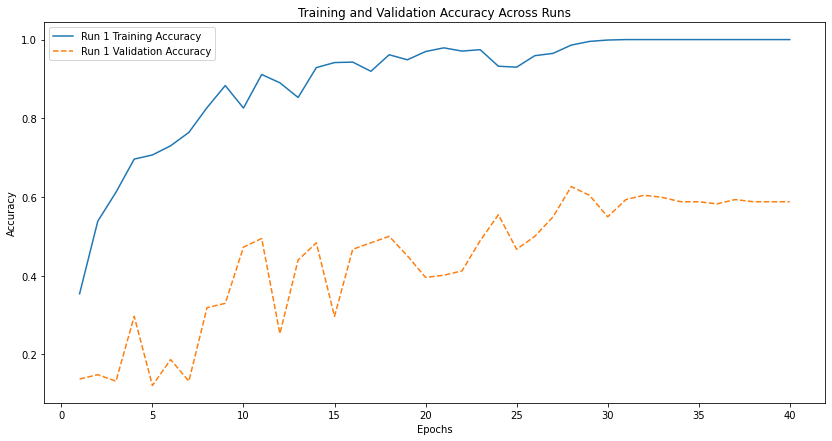

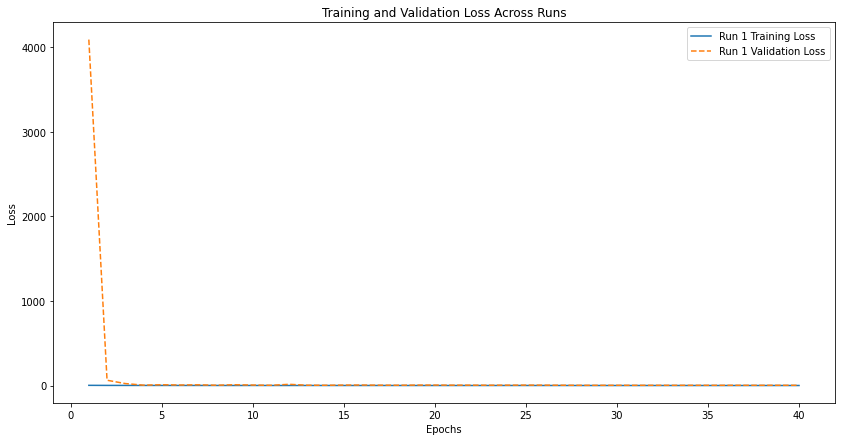

In [5]:
# 결과 시각화 함수
def plot_comparison(all_train_acc, all_val_acc, all_train_loss, all_val_loss):
    epochs_range = range(1, epochs + 1)
    
    # Accuracy 그래프
    plt.figure(figsize=(14, 7))
    
    # Training Accuracy
    for i, train_acc in enumerate(all_train_acc):
        plt.plot(epochs_range, train_acc, label=f'Run {i+1} Training Accuracy')
    # Validation Accuracy
    for i, val_acc in enumerate(all_val_acc):
        plt.plot(epochs_range, val_acc, linestyle='--', label=f'Run {i+1} Validation Accuracy')
    
    plt.title('Training and Validation Accuracy Across Runs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss 그래프
    plt.figure(figsize=(14, 7))
    
    # Training Loss
    for i, train_loss in enumerate(all_train_loss):
        plt.plot(epochs_range, train_loss, label=f'Run {i+1} Training Loss')
    # Validation Loss
    for i, val_loss in enumerate(all_val_loss):
        plt.plot(epochs_range, val_loss, linestyle='--', label=f'Run {i+1} Validation Loss')
    
    plt.title('Training and Validation Loss Across Runs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 결과 시각화 호출
plot_comparison(all_train_acc, all_val_acc, all_train_loss, all_val_loss)